C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


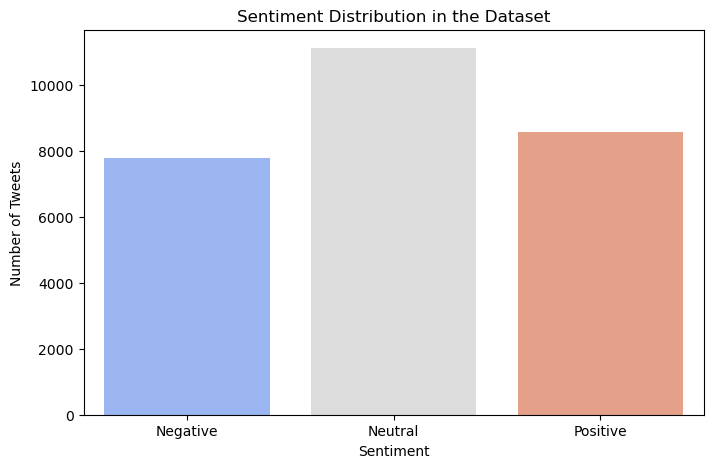

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,0,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,0,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons of why couldnt they put them on the relea...


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the dataset
file_path ="Tweets.csv"
df = pd.read_csv(file_path, encoding="latin1")

# Remove missing values, in this case by dropping rows where the 'text' column is empty
df.dropna(subset=["text"], inplace=True)

# Converting sentiment labels to numerical values; this makes it easier for the models to process the data
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

# Clean text
def clean_tweet(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Applying text cleaning function
df["clean_text"] = df["text"].apply(clean_tweet)

# Count the number of tweets per sentiment category
sentiment_counts = df["sentiment"].value_counts().sort_index()

# Map sentiment labels back for visualisation
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Plot the sentiment distribution
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution in the Dataset")
plt.show()

df.head()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TF-IDF Vectorizer which helps convert text into numerical values based on word importance
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important words

# Convert text data into TF-IDF numerical representation 
X = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["sentiment"]  # Defining target variable

# # The dataset is split in 80% train and 20% test to ensure enough data for training while reserving unseen data for evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset shape after transformation
X_train.shape, X_test.shape


((21984, 5000), (5496, 5000))

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train the SVM model 
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_predictions = svm_model.predict(X_test)

# Create a classification report for SVM
svm_report = classification_report(y_test, svm_predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True)

# Converting classification report to a DataFrame
df_svm_report = pd.DataFrame({
    "Precision": [svm_report["Negative"]["precision"], svm_report["Neutral"]["precision"], svm_report["Positive"]["precision"]],
    "Recall": [svm_report["Negative"]["recall"], svm_report["Neutral"]["recall"], svm_report["Positive"]["recall"]],
    "F1-Score": [svm_report["Negative"]["f1-score"], svm_report["Neutral"]["f1-score"], svm_report["Positive"]["f1-score"]],
    "Accuracy": [svm_report["accuracy"], svm_report["accuracy"], svm_report["accuracy"]]
}, index=["Negative", "Neutral", "Positive"])

# Round values 
df_svm_report = df_svm_report.round(3)

# Display classification report for SVM
display(df_svm_report)

,Precision,Recall,F1-Score,Accuracy
Negative,0.725,0.581,0.645,0.699
Neutral,0.628,0.773,0.693,0.699
Positive,0.808,0.711,0.756,0.699


In [12]:
# Test the tweets 
test_tweets = [
    "I absolutely love this product! It's the best thing ever!",  
    "This is the worst service I've ever received!",  
    "The movie was okay, not great but not terrible.",  
    "I don't know what to think about this update.", 
    "Amazing concert! The performance was mind-blowing!", 
    "I waited hours and still no response from customer support!", 
    "The weather today is fine, nothing special.",  
    "I'm really enjoying this new app, it's so useful!", 
    "The delivery was late but the food was still warm, so it's okay.",  
    "Absolutely horrible experience. Never using this again!",  
]

# Convert test tweets into TF-IDF format
test_tfidf = tfidf_vectorizer.transform(test_tweets)

# Predict sentiment for test tweets
test_predictions = svm_model.predict(test_tfidf)

# Map numerical predictions to sentiment labels
sentiment_classes = {0: "Negative", 1: "Neutral", 2: "Positive"}
test_predicted_sentiments = [sentiment_classes[label] for label in test_predictions]

# Display results
df_test_results = pd.DataFrame({"Tweet": test_tweets, "Predicted Sentiment": test_predicted_sentiments})
display(df_test_results)

,Tweet,Predicted Sentiment
0,I absolutely love this product! It's the best ...,Positive
1,This is the worst service I've ever received!,Negative
2,"The movie was okay, not great but not terrible.",Negative
3,I don't know what to think about this update.,Neutral
4,Amazing concert! The performance was mind-blow...,Positive
5,I waited hours and still no response from cust...,Neutral
6,"The weather today is fine, nothing special.",Positive
7,"I'm really enjoying this new app, it's so useful!",Positive
8,The delivery was late but the food was still w...,Neutral
9,Absolutely horrible experience. Never using th...,Negative


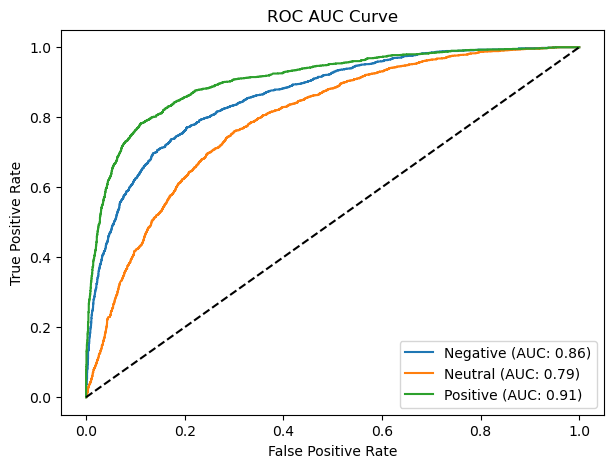

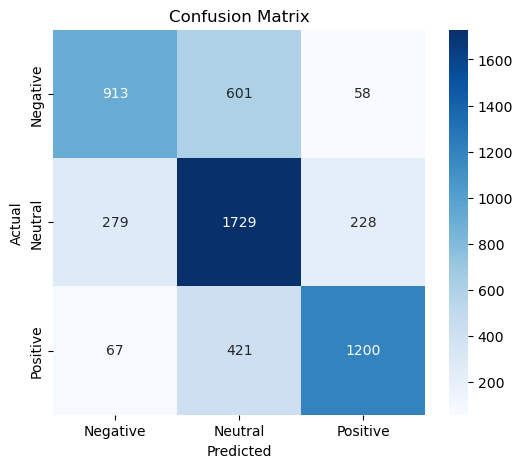

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

# Compute ROC-AUC scores 
y_test_bin = pd.get_dummies(y_test)  
svm_probs = svm_model.predict_proba(X_test)  # Get prediction probabilities

# Compute ROC Curve for each class
plt.figure(figsize=(7, 5))
for i, sentiment in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], svm_probs[:, i])
    plt.plot(fpr, tpr, label=f"{sentiment} (AUC: {roc_auc_score(y_test_bin.iloc[:, i], svm_probs[:, i]):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
